## Calcul de l'attention (avec numpy)

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
# ------------------------
# Fonction d'attention (inchangée)
# ------------------------
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def run_attention_once(x, block_size):
    seq_len, d_model = x.shape
    output = np.zeros_like(x)
    for i in range(0, seq_len, block_size):
        end = min(i + block_size, seq_len)
        Q = x[i:end]
        K = x[i:end]
        V = x[i:end]
        scores = Q @ K.T / np.sqrt(d_model)
        weights = softmax(scores)
        output[i:end] = weights @ V
    return output

## Grille exhaustive qui teste toutes les combinaisons

* Mesure initiale : pour chaque block_size, effectue initial_repeats mesures et stocke les temps.

* Choix du candidat : identifie le bloc dont la moyenne des temps initiaux est la plus faible.

* Échauffement : relance 5 mesures supplémentaires sur ce “best” pour estimer son intervalle de confiance (IC) à 95 % (Student-t).

* Itération : jusqu’à max_iter, répète :

* Recalcule la moyenne, l’écart-type et l’IC supérieur du “best”.

* Sélectionne tous les blocs dont la moyenne courante ≤ IC supérieur.

* Mesure chacun de ces candidats une fois de plus.

* Met à jour le “best” en choisissant, parmi les candidats, celui à la plus petite moyenne.

* Test de confiance : pour chaque autre bloc, effectue un test t de Welch contre le “best” et calcule la p-value unilatérale.

* Arrêt : dès que toutes les p-values sont < 0.05 (95 % de confiance que le “best” est plus rapide), on sort.

* Résultat : retourne la taille de bloc optimale, toutes les mesures accumulées, et le nombre total de tests effectués.

In [32]:
import numpy as np
import time
import math
from math import sqrt
from scipy.stats import t as student_t
import matplotlib.pyplot as plt


# ------------------------
# Mesure de temps
# ------------------------
def measure_time(x, block_size):
    start = time.perf_counter()
    _ = run_attention_once(x, block_size)
    return time.perf_counter() - start

# ------------------------
# Grille jusqu'à confiance 95%
# ------------------------
def exhaustive_grid_until_confidence(x, block_sizes,
                                     initial_repeats=3,
                                     confidence=0.95,
                                     max_iter=100):
    alpha = 1 - confidence
    block_sizes = sorted(set(block_sizes))
    n_blocks = len(block_sizes)
    results = {b: [] for b in block_sizes}

    # Phase initiale
    print("🔍 Phase 1 : mesures initiales")
    for b in block_sizes:
        for _ in range(initial_repeats):
            time_val = measure_time(x, b)
            results[b].append(time_val)
        med = np.median(results[b])
        print(f"Bloc {b:<4} → médiane init : {med:.5f} s")

    total_tests = initial_repeats * n_blocks

    # Itérations
    for iteration in range(1, max_iter+1):
        print(f"\n🔁 Itération {iteration} : mesure de tous les blocs")
        # Mesurer chaque bloc
        for b in block_sizes:
            time_val = measure_time(x, b)
            results[b].append(time_val)
            print(f" Bloc {b:<4} dernière mesure : {time_val:.5f} s, essais : {len(results[b])}")
        total_tests += n_blocks

        # Statistiques par bloc
        means = {b: np.mean(results[b]) for b in block_sizes}
        vars_ = {b: np.var(results[b], ddof=1) for b in block_sizes}
        ns = {b: len(results[b]) for b in block_sizes}

        # Sélection du meilleur moyen actuel
        best = min(means, key=means.get)
        print(f" Meilleur moyen actuel : Bloc {best} (mean={means[best]:.5f})")

        # Test de confiance pair à pair
        all_confident = True
        for b in block_sizes:
            if b == best: 
                continue
            diff = means[b] - means[best]
            var_diff = vars_[b]/ns[b] + vars_[best]/ns[best]
            t_stat = diff / math.sqrt(var_diff)
            # Degrés de liberté Welch-Satterthwaite
            df = (var_diff**2) / ((vars_[b]**2)/(ns[b]**2*(ns[b]-1)) +
                                  (vars_[best]**2)/(ns[best]**2*(ns[best]-1)))
            p_value = 1 - student_t.cdf(t_stat, df)
            print(f"  -> Bloc {best} vs Bloc {b}: p={p_value:.4f}")
            if p_value >= alpha:
                all_confident = False

        if all_confident:
            print("\n✅ Confiance 95% atteinte pour le meilleur bloc.")
            break

    print(f"\n✅ Résultat final : Bloc {best}, tests totaux = {total_tests}")
    return best, results, total_tests


In [33]:
# ------------------------
# Exécution test
# ------------------------
if __name__ == "__main__":
    seq_len, d_model = 1024, 64
    x = np.random.randn(seq_len, d_model)
    blocks = range(64, 1024, 32) # Taille de bloc à tester

    best, results, total_tests = exhaustive_grid_until_confidence(
        x, blocks, initial_repeats=3, confidence=0.95, max_iter=10
    )

🔍 Phase 1 : mesures initiales
Bloc 64   → médiane init : 0.00380 s
Bloc 96   → médiane init : 0.00482 s
Bloc 128  → médiane init : 0.00173 s
Bloc 160  → médiane init : 0.00172 s
Bloc 192  → médiane init : 0.00243 s
Bloc 224  → médiane init : 0.00274 s
Bloc 256  → médiane init : 0.00274 s
Bloc 288  → médiane init : 0.00701 s
Bloc 320  → médiane init : 0.00595 s
Bloc 352  → médiane init : 0.00759 s
Bloc 384  → médiane init : 0.00627 s
Bloc 416  → médiane init : 0.00905 s
Bloc 448  → médiane init : 0.00754 s
Bloc 480  → médiane init : 0.01252 s
Bloc 512  → médiane init : 0.01146 s
Bloc 544  → médiane init : 0.01324 s
Bloc 576  → médiane init : 0.01001 s
Bloc 608  → médiane init : 0.01223 s
Bloc 640  → médiane init : 0.00880 s
Bloc 672  → médiane init : 0.00961 s
Bloc 704  → médiane init : 0.00719 s
Bloc 736  → médiane init : 0.00807 s
Bloc 768  → médiane init : 0.01152 s
Bloc 800  → médiane init : 0.01021 s
Bloc 832  → médiane init : 0.01459 s
Bloc 864  → médiane init : 0.01384 s
Bloc 896

# Benchmark intelligent

### Adaptativité
Plutôt que de tester exhaustivement toutes les tailles de bloc à chaque itération, l’algorithme se focalise sur un sous-ensemble prometteur, ce qui réduit fortement le nombre total de mesures.

### Estimation statistique du « best »
À chaque étape, on construit pour le bloc courant un intervalle de confiance (IC) à 95 % basé sur ses temps d’exécution accumulés (Student-t). Cet IC donne une borne supérieure réaliste sur sa performance réelle.

### Sélection des candidats
On ne reteste que les tailles de bloc dont la moyenne des temps mesurés jusqu’ici est inférieure ou égale à cette borne supérieure. Ce sont les seules qui pourraient raisonnablement être plus rapides que le best actuel.

### Mise à jour conditionnelle
Parmi ces candidats, on met à jour le best seulement si un test statistique (Welch) montre qu’il y a au moins 50 % de chance qu’ils soient vraiment plus rapides que l’ancien best.

### Itérations jusqu’à confiance
Le processus se répète : on raffine la moyenne et l’IC du nouveau best, on sélectionne à nouveau les candidats sous cet IC, on les mesure, etc., jusqu’à obtenir la confiance statistique (p-value < 0.05 pour tous les autres blocs) que notre best est vraiment le plus rapide.

### Avantages

➕ Moins de tests : on n’explore jamais les configurations manifestement lentes.

🎯 Ciblé : on concentre les mesures sur les options qui ont une chance statistique de l’emporter.

🔍 Rigueur : l’utilisation d’IC et de tests de Student-Welch garantit qu’on ne change de best que lorsqu’il y a une preuve fiable.

⚖️ Équilibré : on combine exploration (mesure initiale de tous) et exploitation (mesures répétées du best et de ses challengers).

Cet algorithme est donc un benchmark intelligent car il allie statistiques et sélection adaptative, maximisant l’information acquise tout en minimisant le coût de mesure.

In [6]:
import numpy as np
import time
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm
from scipy.stats import t as student_t


In [7]:
np.random.seed(0)

In [8]:
# ------------------------
# Fonction d'attention (inchangée)
# ------------------------
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def run_attention_once(x, block_size):
    seq_len, d_model = x.shape
    output = np.zeros_like(x)
    for i in range(0, seq_len, block_size):
        end = min(i + block_size, seq_len)
        Q = x[i:end]
        K = x[i:end]
        V = x[i:end]
        scores = Q @ K.T / np.sqrt(d_model)
        weights = softmax(scores)
        output[i:end] = weights @ V
    return output

# ------------------------
# Mesure de temps
# ------------------------
def measure_time(x, block_size):
    start = time.perf_counter()
    _ = run_attention_once(x, block_size)
    return time.perf_counter() - start

In [ ]:
# ------------------------
# Benchmark intelligent jusqu'à confiance
# ------------------------
def smart_benchmark_until_confidence(x, block_sizes,
                                     confidence=0.95,
                                     initial_repeats=1,
                                     max_iter=1000,
                                     free_runs=5,
                                     verbose=True):
    """
    Itératif :
    - Phase initiale : 1 mesure par bloc + free_runs pour chauffer
    - Sélection initiale du best, puis repeats sur le best pour estimer CI
    - À chaque itération :
       * On calcule CI supérieur pour le best
       * On sélectionne les blocs dont la moyenne <= CI (candidats)
       * On mesure seulement ces candidats
       * On met à jour le best = argmin mean parmi candidats
       * On teste si best est meilleur que tous les blocs avec p > confidence
    """
    block_sizes = sorted(set(block_sizes))
    results = {b: [] for b in block_sizes}
    history = []
    best_blocks_by_iter = []

    # Free runs
    for _ in range(free_runs):
        for b in block_sizes:
            run_attention_once(x, b)

    # Initial measurements
    if verbose: print("🔍 Phase 1 : évaluation initiale")
    for b in block_sizes:
        t = measure_time(x, b)
        results[b].append(t)
        if verbose: print(f"Bloc {b:<4} → {t:.5f} s")

    # Initial best and CI estimation (5 repeats)
    best = min(block_sizes, key=lambda b: np.mean(results[b]))
    if verbose: print(f"\nBest initial block: {best}")
    for _ in range(5):
        results[best].append(measure_time(x, best))

    # Iterative refinement
    for iteration in range(1, max_iter+1):
        # Compute best stats and CI
        times_best = np.array(results[best])
        n_best = len(times_best)
        m_best = times_best.mean()
        s_best = times_best.std(ddof=1)
        t_crit = student_t.ppf(1 - (1 - confidence)/2, df=n_best-1)
        ci_upper = m_best + t_crit*(s_best/sqrt(n_best))
        history.append((iteration, best, m_best, s_best, ci_upper))
        best_blocks_by_iter.append(best)
        if verbose:
            print(f"\n🔁 Itération {iteration}: Best={best}, mean={m_best:.5f}, σ={s_best:.5f}, CI_up={ci_upper:.5f}")

        # Select candidates within CI
        candidates = [b for b in block_sizes if np.mean(results[b]) <= ci_upper]
        if verbose:
            print("Candidats pour mesure:", candidates)

        # Measure candidates
        for b in candidates:
            t_b = measure_time(x, b)
            results[b].append(t_b)
            if verbose:
                print(f"Bloc {b:<4} → {t_b:.5f} s")

        # Update best among candidates
        best = min(candidates, key=lambda b: np.mean(results[b]))
        if verbose:
            print("Best mis à jour:", best)

        # Test confidence best vs all blocks
        all_confident = True
        for b in block_sizes:
            if b == best: continue
            mean_b = np.mean(results[b])
            var_diff = (s_best**2)/n_best + (np.std(results[b], ddof=1)**2)/len(results[b])
            diff = mean_b - m_best
            t_stat = diff / sqrt(var_diff)
            # Welch-Satterthwaite df
            df = (var_diff**2)/(((s_best**4)/(n_best**2*(n_best-1))) + ((np.std(results[b], ddof=1)**4)/(len(results[b])**2*(len(results[b])-1))))
            p = student_t.cdf(t_stat, df)
            if verbose:
                print(f"  P({best} < {b}) = {p:.3f}")
            if p < confidence:
                all_confident = False
        if all_confident:
            if verbose: print("\n✅ Confiance atteinte pour le best.")
            break

    if verbose:
        final_med = float(np.median(results[best]))
        print(f"\n✅ Best final: {best} ({final_med:.5f} s)")
        print("Tests totaux:", sum(len(v) for v in results.values()))

    return best, results, history, best_blocks_by_iter

# ------------------------
    # Le code courant renvoie :

    # best : taille de bloc optimale

    # results : tous les temps mesurés par bloc

    # history : infos par itération (pour tracer l’IC)

    # best_blocks_by_iter : quel bloc était best à chaque itération


* **Données et benchmark**
Crée une figure à deux sous-graphiques (axes\[0] et axes\[1]) côte à côte, taille 12×10.

* **Sous-graphe du haut (nuage + IC)**
Pour chaque bloc, trace un **nuage de points** (`scatter`) des temps enregistrés (`results[b]`) en abscisse = taille de bloc, ordonnée = temps.

Pour chaque itération, ajoute une **barre d’erreur** (`errorbar`) au niveau du best courant :

  * point à la moyenne `m`
  * barre verticale de `m → CI_sup`
  * légendé “IC best” sur la première itération.

Force les **graduations de l’axe x** sur les valeurs `blocks` et incline les étiquettes à 45° pour la lisibilité.

* **Sous-graphe du bas (moyenne & IC)**
Trace l’**évolution de la moyenne** du best au fil des itérations (`plot` avec marqueurs cercles).

Trace l’**évolution du CI supérieur** (`plot` avec carrés) et colorie la zone entre moyenne et CI (`fill_between`, couleur orange, α=0.3).

🔍 Phase 1 : évaluation initiale
Bloc 64   → 0.00218 s
Bloc 96   → 0.00351 s
Bloc 128  → 0.01116 s
Bloc 160  → 0.00365 s
Bloc 192  → 0.00492 s
Bloc 224  → 0.00216 s
Bloc 256  → 0.00257 s
Bloc 288  → 0.00448 s
Bloc 320  → 0.00330 s
Bloc 352  → 0.00366 s
Bloc 384  → 0.00328 s
Bloc 416  → 0.00499 s
Bloc 448  → 0.00448 s
Bloc 480  → 0.00677 s
Bloc 512  → 0.00567 s
Bloc 544  → 0.00440 s
Bloc 576  → 0.00581 s
Bloc 608  → 0.00473 s
Bloc 640  → 0.01025 s
Bloc 672  → 0.00442 s
Bloc 704  → 0.00538 s
Bloc 736  → 0.00607 s
Bloc 768  → 0.00822 s
Bloc 800  → 0.00680 s
Bloc 832  → 0.01327 s
Bloc 864  → 0.01740 s
Bloc 896  → 0.03039 s
Bloc 928  → 0.01243 s
Bloc 960  → 0.01949 s
Bloc 992  → 0.01997 s

Best initial block: 224

🔁 Itération 1:
 - Seuil = 0.01082 s (moyenne = 0.00626, σ = 0.00493)
  Test best vs 64: t_stat=2.40, prob_better=0.976
  Test best vs 96: t_stat=0.78, prob_better=0.769
  Test best vs 128: t_stat=-0.06, prob_better=0.479
  Test best vs 160: t_stat=0.73, prob_better=0.753
  Test bes

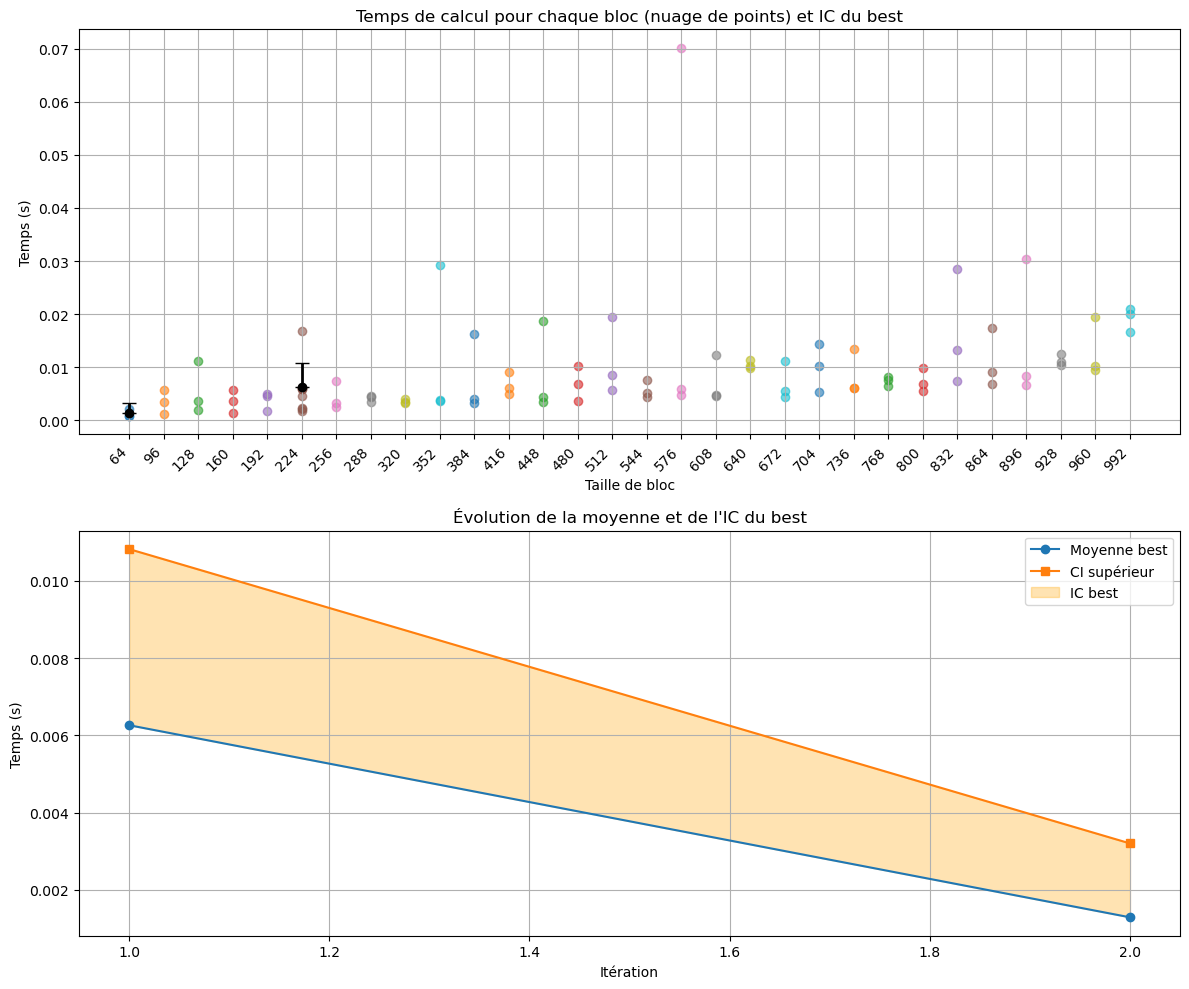

In [16]:
# ------------------------
# Exécution et double graphique
# ------------------------
if __name__ == "__main__":
    seq_len, d_model = 1024, 64
    x = np.random.randn(seq_len, d_model)
    blocks = range(64, 1024, 32) # Taille de bloc à tester
    best, results, hist, best_blocks_by_iter = smart_benchmark_gaussian(x, blocks)

    # Tracé
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

    # --- HAUT : nuage de points de tous les temps + IC best par itération ---
    # On positionne chaque point selon son bloc (axe x=bloc, axe y=temps)
    for b in blocks:
        y = results[b]
        x_b = [b] * len(y)
        axes[0].scatter(x_b, y, label=f"Bloc {b}", alpha=0.6)
    # Ajout de l'évolution de l'IC du bloc best
    ic_means = []
    ic_uppers = []
    ic_locs = []
    for i, (iteration, bestb, m, s, ci_upper) in enumerate(hist):
        ic_means.append(m)
        ic_uppers.append(ci_upper)
        ic_locs.append(bestb)
        axes[0].errorbar(bestb, m, yerr=[[0], [ci_upper - m]], fmt='o', color='black', capsize=5, lw=2, label='IC best' if i==0 else "")

    # On force les graduations de l'axe x sur les blocs testés
    axes[0].set_xticks(list(blocks))
    axes[0].set_xticklabels([str(b) for b in blocks], rotation=45, ha="right")
    
    axes[0].set_title("Temps de calcul pour chaque bloc (nuage de points) et IC du best")
    axes[0].set_xlabel("Taille de bloc")
    axes[0].set_ylabel("Temps (s)")
    if len(blocks) < 20:
        axes[0].set_xticks(list(blocks))
        axes[0].legend()
    axes[0].grid(True)

    # --- BAS : évolution de la moyenne et de l'IC du best ---
    iterations = [h[0] for h in hist]
    axes[1].plot(iterations, ic_means, marker='o', label='Moyenne best')
    axes[1].plot(iterations, ic_uppers, marker='s', label='CI supérieur')
    axes[1].fill_between(iterations, ic_means, ic_uppers, color='orange', alpha=0.3, label='IC best')
    axes[1].set_xlabel("Itération")
    axes[1].set_ylabel("Temps (s)")
    axes[1].set_title("Évolution de la moyenne et de l'IC du best")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Benchmark intelligent 2


Itératif :
- Phase initiale : mesures initiales + free_runs pour chauffer la machine
- Estimation CI initiale pour le best (5 runs)

À chaque itération :
1) Calcul de l’intervalle de confiance supérieur pour le best
2) Sélection des candidats dont la moyenne <= CI
3) **Mesure uniquement ces candidats**
4) Mise à jour du best si un candidat a p_val >= 1 - confidence
5) Arrêt lorsque pour tous les candidats p_val < confidence (i.e. < 0.05 si confidence=0.95)


In [ ]:
import numpy as np
import time
from math import sqrt
from scipy.stats import t as student_t

# ------------------------
# Benchmark intelligent jusqu'à confiance 95%
# ------------------------
def smart_benchmark_until_confidence(x, block_sizes,
                                     confidence=0.95,
                                     initial_repeats=1,
                                     max_iter=1000,
                                     free_runs=5,
                                     verbose=True):
    """
    Itératif :
    - Phase initiale : mesures initiales + free_runs pour chauffer la machine
    - Estimation CI initiale pour le best (5 runs)
    - À chaque itération :
      1) Calcul de l’intervalle de confiance supérieur pour le best
      2) Sélection des candidats dont la moyenne <= CI
      3) Mesure uniquement ces candidats
      4) Mise à jour du best si un candidat a p_val >= 1 - confidence
      5) Arrêt lorsque pour tous les candidats p_val < confidence (i.e. < 0.05 si confidence=0.95)
    """
    alpha = 1 - confidence
    block_sizes = sorted(set(block_sizes))
    results = {b: [] for b in block_sizes}
    history = []
    best_blocks_by_iter = []

    # Free runs pour chauffer
    for _ in range(free_runs):
        for b in block_sizes:
            run_attention_once(x, b)

    # Phase initiale : 1 run par bloc
    if verbose: print("🔍 Phase 1 : évaluation initiale")
    for b in block_sizes:
        t = measure_time(x, b)
        results[b].append(t)
        if verbose: print(f"Bloc {b:<4} → {t:.5f} s")

    # Sélection initiale du best et CI de départ
    best = min(block_sizes, key=lambda b: np.mean(results[b]))
    if verbose: print(f"\nBest initial block: {best}")
    for _ in range(5):
        results[best].append(measure_time(x, best))

    # Itérations
    for iteration in range(1, max_iter+1):
        # 1) CI pour le best
        times_best = np.array(results[best])
        n_best = len(times_best)
        m_best = times_best.mean()
        s_best = times_best.std(ddof=1)
        t_crit = student_t.ppf(1 - alpha/2, df=n_best-1)
        ci_upper = m_best + t_crit * (s_best / sqrt(n_best))
        history.append((iteration, best, m_best, s_best, ci_upper))
        best_blocks_by_iter.append(best)
        if verbose:
            print(f"\n🔁 Itération {iteration}: Best={best}, mean={m_best:.5f}, σ={s_best:.5f}, CI_up={ci_upper:.5f}")

        # 2) Sélection des candidats (moyenne <= CI)
        candidates = [b for b in block_sizes if np.mean(results[b]) <= ci_upper]
        if verbose:
            print("Candidats CI:", candidates)

        # 3) Mesure des candidats
        for b in candidates:
            t_b = measure_time(x, b)
            results[b].append(t_b)
            if verbose:
                print(f"Bloc {b:<4} nouvelle mesure : {t_b:.5f} s")

        # 4) Calcul des p_val et mise à jour du best si p_val >= 1-alpha
        p_vals = {}
        for b in candidates:
            if b == best: continue
            times_b = np.array(results[b])
            n_b = len(times_b)
            m_b = times_b.mean()
            s_b = times_b.std(ddof=1)
            diff = m_best - m_b
            var_diff = (s_best**2)/n_best + (s_b**2)/n_b
            t_stat = diff / sqrt(var_diff)
            df = (var_diff**2) / (((s_best**4)/(n_best**2*(n_best-1))) +
                                  ((s_b**4)/(n_b**2*(n_b-1))))
            p_val = 1 - student_t.cdf(t_stat, df)  # P(candidate faster than best)
            p_vals[b] = p_val
            if verbose:
                print(f"  P({b} faster than {best}) = {p_val:.3f}")

        # Mettre à jour best si un candidat est clairement meilleur
        better = [b for b, p in p_vals.items() if p >= confidence]
        if better:
            new_best = min(better, key=lambda b: np.mean(results[b]))
            if verbose:
                print("Best mis à jour :", new_best)
            best = new_best

        # 5) Arrêt si pour tous p_val < confidence (i.e. aucun candidat n’est significatif)
        if all(p < confidence for p in p_vals.values()):
            if verbose:
                print("\n✅ Confiance atteinte : aucun candidat n’est meilleur avec p >= {:.2f}".format(confidence))
            break

    if verbose:
        final_med = float(np.median(results[best]))
        total_tests = sum(len(v) for v in results.values())
        print(f"\n✅ Meilleure taille de bloc : {best} ({final_med:.5f} s)")
        print(f"🧮 Nombre total de tests : {total_tests}")

    return best, results, history, best_blocks_by_iter


🔍 Phase 1 : évaluation initiale
Bloc 64   → 0.00225 s
Bloc 96   → 0.00187 s
Bloc 128  → 0.00257 s
Bloc 160  → 0.00274 s
Bloc 192  → 0.00547 s
Bloc 224  → 0.00648 s
Bloc 256  → 0.00693 s
Bloc 288  → 0.01062 s
Bloc 320  → 0.00866 s
Bloc 352  → 0.02093 s
Bloc 384  → 0.01376 s
Bloc 416  → 0.00776 s
Bloc 448  → 0.00808 s
Bloc 480  → 0.00733 s
Bloc 512  → 0.01204 s
Bloc 544  → 0.02070 s
Bloc 576  → 0.00927 s
Bloc 608  → 0.00998 s
Bloc 640  → 0.00752 s
Bloc 672  → 0.01377 s
Bloc 704  → 0.00931 s
Bloc 736  → 0.01710 s
Bloc 768  → 0.01349 s
Bloc 800  → 0.01769 s
Bloc 832  → 0.00805 s
Bloc 864  → 0.00875 s
Bloc 896  → 0.01023 s
Bloc 928  → 0.01055 s
Bloc 960  → 0.01164 s
Bloc 992  → 0.01577 s

Best initial block: 96

🔁 Itération 1:
 - Seuil = 0.00305 s (moyenne = 0.00247, σ = 0.00063)
  Test best vs 64: t_stat=1.24, prob_better=0.799
  Test best vs 128: t_stat=-1.08, prob_better=0.213
  Test best vs 160: t_stat=-0.37, prob_better=0.364
  Test best vs 192: t_stat=-0.98, prob_better=0.250
  Test b

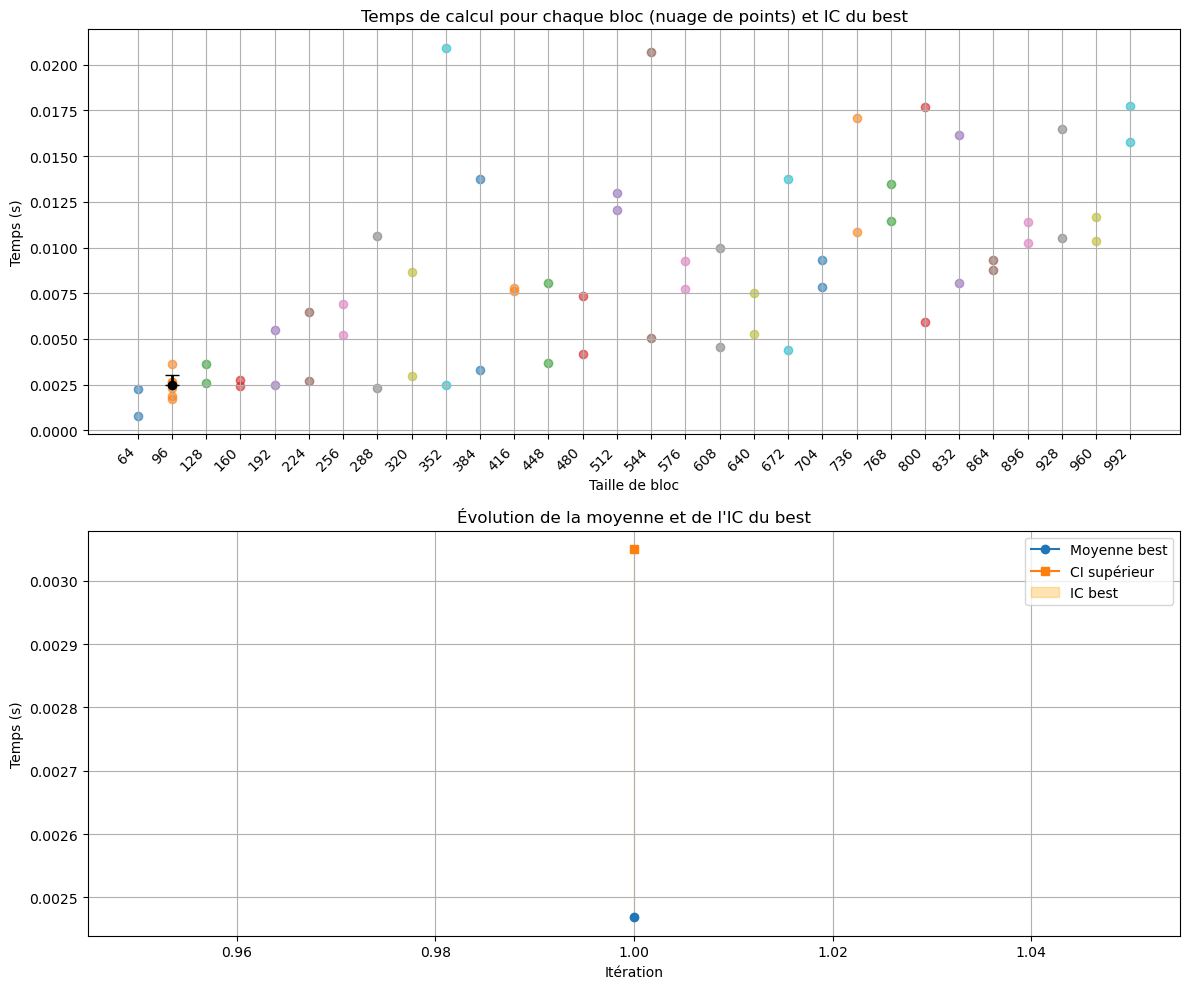

In [66]:
# ------------------------
# Exécution et double graphique
# ------------------------
if __name__ == "__main__":
    seq_len, d_model = 1024, 64
    x = np.random.randn(seq_len, d_model)
    blocks = range(64, 1024, 32) # Taille de bloc à tester
    best, results, hist, best_blocks_by_iter = smart_benchmark_gaussian(x, blocks)

    # Tracé
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

    # --- HAUT : nuage de points de tous les temps + IC best par itération ---
    # On positionne chaque point selon son bloc (axe x=bloc, axe y=temps)
    for b in blocks:
        y = results[b]
        x_b = [b] * len(y)
        axes[0].scatter(x_b, y, label=f"Bloc {b}", alpha=0.6)
    # Ajout de l'évolution de l'IC du bloc best
    ic_means = []
    ic_uppers = []
    ic_locs = []
    for i, (iteration, bestb, m, s, ci_upper) in enumerate(hist):
        ic_means.append(m)
        ic_uppers.append(ci_upper)
        ic_locs.append(bestb)
        axes[0].errorbar(bestb, m, yerr=[[0], [ci_upper - m]], fmt='o', color='black', capsize=5, lw=2, label='IC best' if i==0 else "")

    # On force les graduations de l'axe x sur les blocs testés
    axes[0].set_xticks(list(blocks))
    axes[0].set_xticklabels([str(b) for b in blocks], rotation=45, ha="right")
    
    axes[0].set_title("Temps de calcul pour chaque bloc (nuage de points) et IC du best")
    axes[0].set_xlabel("Taille de bloc")
    axes[0].set_ylabel("Temps (s)")
    if len(blocks) < 20:
        axes[0].set_xticks(list(blocks))
        axes[0].legend()
    axes[0].grid(True)

    # --- BAS : évolution de la moyenne et de l'IC du best ---
    iterations = [h[0] for h in hist]
    axes[1].plot(iterations, ic_means, marker='o', label='Moyenne best')
    axes[1].plot(iterations, ic_uppers, marker='s', label='CI supérieur')
    axes[1].fill_between(iterations, ic_means, ic_uppers, color='orange', alpha=0.3, label='IC best')
    axes[1].set_xlabel("Itération")
    axes[1].set_ylabel("Temps (s)")
    axes[1].set_title("Évolution de la moyenne et de l'IC du best")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()